## A quick introduction to HDF5 files for seismic

We will read a preformed dataset from a NumPy file, then save the dataset as an HDF5 file.

This notebook follows on from `Intro_to_seismic.ipynb`.

## What are HDF5 files?

'HDF' stands for _hierarchical data format_. 

An HDF5 **File** can contain multiple **Group** and **Dataset** items. 

- A **Group** is a bit like a file system directory, and a bit like a Python dictionary. Groups can be arbitrarily nested (hence the _H_ in HDF). They can contain Datasets, or other Groups. The **File** is, for all intents and purposes, a root-level group.

- A **Dataset** is a lot like a NumPy array. It's an n-dimensional (hyper-)rectangular data object, containing elements of homogenous type.

Both Groups and Datasets can have **Attributes**: a dictionary-like `attrs` object attached to them, which holds metadata.

HDF5 files support compression, error detection, metadata, and other useful things. They also support chunking, which can dramatically speed up data access on large files ([more about this](http://geology.beer/2015/02/10/hdf-for-large-arrays/)). 

In [1]:
import numpy as np

import matplotlib.pyplot as plt

In [2]:
volume = np.load('data/F3_volume_3x3_16bit.npy')

In [3]:
volume.shape

(194, 299, 451)

## Saving to HDF5

We'll be using the HDF5 library, via [the `h5py` Python library](http://docs.h5py.org/en/stable/index.html).

If you need to, you can install `h5py` from the Notebook with: `!conda install h5py`. 

In [4]:
import h5py

The `h5py.File` object is a context manager, so we will use it that way. Let's write our seismic volume to an HDF5 file:

In [5]:
with h5py.File('data/f3_seismic.hdf5', 'w') as f:
    dset = f.create_dataset("volume", data=volume)

That has saved a file:

In [6]:
%ls -l data/f3_seismic.hdf5

-rw-r--r--  1 Evan  staff  52323460 29 Jul 15:26 data/f3_seismic.hdf5


This is a bit bigger than the array:

In [7]:
volume.nbytes

52321412

So there's a little bit more overhead than a NumPy binary file:

In [8]:
%ls -l data/F3_volume_3x3_16bit.npy

-rw-r--r--  1 Evan  staff  52321492  6 Jul 15:39 data/F3_volume_3x3_16bit.npy


We can compress the dataset (there's not a lot you can do on this data, but it does squeeze down a bit) &mdash; this reduces the file size, but takes a little time.

In [9]:
with h5py.File('data/f3_seismic.hdf5', 'w') as f:
    dset = f.create_dataset("volume", data=volume, compression='gzip')

In [11]:
%ls -l data/f3_seismic.hdf5

-rw-r--r--  1 Evan  staff  46060173 29 Jul 15:26 data/f3_seismic.hdf5


Let's add a bit of metadata:

In [12]:
with h5py.File('data/f3_seismic.hdf5', 'w') as f:
    grp = f.create_group('amplitude_group')

    dset = f.create_dataset("amplitude_group/timeseries_dataset", data=volume)
    
    # Let's add some attributes (metadata) to the root-level File object...
    f.attrs['survey'] = 'F3'
    f.attrs['location'] = 'Netherlands'
    f.attrs['owner'] = 'NAM/NLOG/TNO/dGB'
    f.attrs['licence'] = 'CC-BY-SA'
    
    # ...and to the group...
    grp.attrs['kind'] = 'Raw seismic amplitude, no units'
    
    # ...and to the dataset.
    dset.attrs['domain'] = 'time'
    dset.attrs['dt'] = '0.004'

## Reading HDF5

You will need to poke around a bt to figure out what the paths and datasets are. At first, it's best just to read the metadata, unless you know what you're expecting to find.

In [13]:
with h5py.File('data/f3_seismic.hdf5', 'r') as f:
    print([k for k in f.keys()])
    print([k for k in f.attrs])

['amplitude_group']
['licence', 'location', 'owner', 'survey']


In [14]:
with h5py.File('data/f3_seismic.hdf5', 'r') as f:
    print([k for k in f['amplitude_group'].keys()])
    print([k for k in f['amplitude_group'].attrs])

['timeseries_dataset']
['kind']


Once you've figured out what you want, you can read the data:

In [15]:
with h5py.File('data/f3_seismic.hdf5', 'r') as f:
    data = f['amplitude_group/timeseries_dataset'][:]

In [16]:
data.shape

(194, 299, 451)

But we can also read slices from the volume without loading it all into memory:

In [17]:
with h5py.File('data/f3_seismic.hdf5', 'r') as f:
    data = f['amplitude_group/timeseries_dataset'][..., 200]

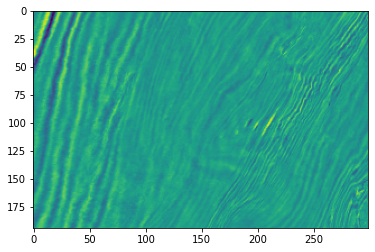

In [18]:
plt.imshow(data)

## Adding a new dataset to an HDF5 file

Let's add a frequency cube with dimensions inlines, crosslines, frequency.

In [19]:
import scipy.signal

freqs, Pxx_den = scipy.signal.welch(volume, fs=250)

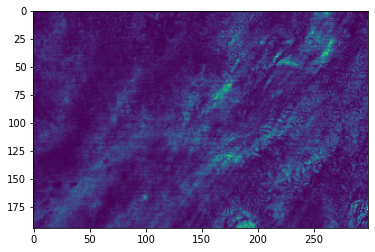

In [20]:
plt.imshow(Pxx_den[:, :, 20])

In [21]:
Pxx_den.shape

(194, 299, 129)

In [22]:
with h5py.File('data/f3_seismic.hdf5', 'r+') as f:

    dset = f.create_dataset("amplitude_group/frequency_dataset", data=Pxx_den)
    
    # This time we only want to add metadata to the dataset.
    dset.attrs['domain'] = 'frequency'
    dset.attrs['df'] = str(125 / 128)

The HDF5 file has grown commensurately:

In [23]:
%ls -l data/f3_seismic.hdf5

-rw-r--r--  1 Evan  staff  82267228 29 Jul 15:27 data/f3_seismic.hdf5


In [24]:
with h5py.File('data/f3_seismic.hdf5', 'r') as f:
    print([k for k in f['amplitude_group'].keys()])
    print([k for k in f['amplitude_group/frequency_dataset'].attrs])

['frequency_dataset', 'timeseries_dataset']
['df', 'domain']


In [25]:
with h5py.File('data/f3_seismic.hdf5', 'r') as f:
    print('domain =', f['amplitude_group/frequency_dataset'].attrs['domain'])
    print('df =', f['amplitude_group/frequency_dataset'].attrs['df'])

domain = frequency
df = 0.9765625


In [26]:
with h5py.File('data/f3_seismic.hdf5', 'r') as f:
    print(np.mean(f['amplitude_group/frequency_dataset']))

43217.348


## Modifying an existing dataset

You can't point a name at a new dataset, but you can change the values inside a dataset &mdash; as long as it doen't change shape.

In [27]:
with h5py.File('data/f3_seismic.hdf5', 'r+') as f:

    data = f["amplitude_group/frequency_dataset"]
    data[...] = np.sqrt(Pxx_den)

In [28]:
with h5py.File('data/f3_seismic.hdf5', 'r') as f:
    print(np.mean(f['amplitude_group/frequency_dataset']))

151.37149


If it changes shape, you'll have to delete it and add it again:

In [29]:
data = np.mean(Pxx_den, axis=1)
data.shape

(194, 129)

In [30]:
with h5py.File('data/f3_seismic.hdf5', 'r+') as f:

    del(f["amplitude_group/frequency_dataset"])

    dset = f.create_dataset("amplitude_group/frequency_dataset", data=data)
    
    # This time we only want to add metadata to the dataset.
    dset.attrs['domain'] = 'frequency'
    dset.attrs['df'] = str(125 / 128)

In [31]:
with h5py.File('data/f3_seismic.hdf5', 'r') as f:
    print(f['amplitude_group/frequency_dataset'].shape)

(194, 129)


<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2018</p>
</div>